<a href="https://colab.research.google.com/github/ParthTiwari246/NeuralNetworks/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
import tensorflow_datasets as tfds
import sklearn
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
ds, info = tfds.load('ag_news_subset', split='train', with_info=True)
train_df = tfds.as_dataframe(ds.take(120_000), info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteQ6T0GQ/ag_news_subset-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteQ6T0GQ/ag_news_subset-test.tfrecord*...:   0%| …

Dataset ag_news_subset downloaded and prepared to ~/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_df.head()
val_df = train_df[90_000:]
train_df = train_df[:90_000]

In [6]:
classes = train_df['label'].unique()
classes

array([3, 1, 2, 0])

In [5]:
encoder = OneHotEncoder(sparse=False)
train_labels_onehot = encoder.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
val_labels_onehot = encoder.transform(val_df['label'].to_numpy().reshape(-1,1))

(array([6.8530e+03, 6.0020e+04, 2.0809e+04, 1.6910e+03, 4.1200e+02,
        1.0500e+02, 6.1000e+01, 3.8000e+01, 9.0000e+00, 2.0000e+00]),
 array([  3. ,  19.5,  36. ,  52.5,  69. ,  85.5, 102. , 118.5, 135. ,
        151.5, 168. ]),
 <a list of 10 Patch objects>)

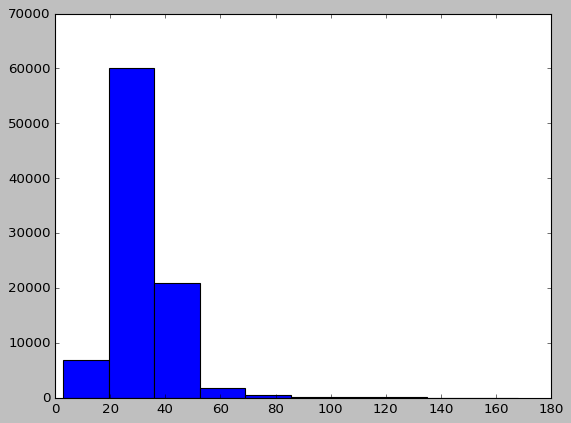

In [7]:
plt.hist([len(i.split()) for i in train_df['description']])

(array([8.5400e+02, 1.0232e+04, 3.1377e+04, 3.0630e+04, 7.9660e+03,
        6.9080e+03, 1.7310e+03, 2.6900e+02, 2.9000e+01, 4.0000e+00]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

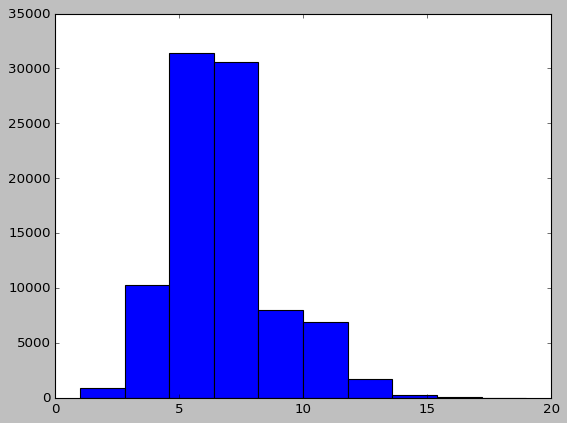

In [8]:
plt.hist([len(i.split()) for i in train_df['title']])

In [9]:
training_sentences = tf.data.Dataset.from_tensor_slices((train_df['title'].tolist(), train_df['description'].tolist()))
training_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot)
training_data = tf.data.Dataset.zip((training_sentences, training_labels))
training_data = training_data.batch(10_000).prefetch(tf.data.AUTOTUNE)


val_sentences = tf.data.Dataset.from_tensor_slices((val_df['title'].tolist(), val_df['description'].tolist()))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_data = tf.data.Dataset.zip((val_sentences, val_labels))
val_data = val_data.batch(10_000).prefetch(tf.data.AUTOTUNE)

In [10]:
title_vectorization = layers.TextVectorization(max_tokens=10_000,
                                               output_sequence_length=15)
title_vectorization.adapt(train_df['title'])
title_embeddig = layers.Embedding(input_dim=10_000,
                                  output_dim=128,
                                  mask_zero=True)




desc_vectoriztion = layers.TextVectorization(max_tokens=20_000,
                                             output_sequence_length=60)
desc_vectoriztion.adapt(train_df['description'])
desc_embedding = layers.Embedding(input_dim=20_000,
                                  output_dim=128,
                                  mask_zero=True)

In [11]:
#--MODEL--
title_inputs = layers.Input(shape=(1,), dtype=tf.string)
title_vectors = title_vectorization(title_inputs)
title_embeds = title_embeddig(title_vectors)
title_layer = layers.Bidirectional(layers.LSTM(64))(title_embeds)
title_outputs = layers.Dense(32, activation='relu')(title_layer)
title_model = Model(title_inputs, title_outputs)

desc_inputs = layers.Input(shape=(1,), dtype=tf.string)
desc_vectors = desc_vectoriztion(desc_inputs)
desc_embeds = desc_embedding(desc_vectors)
desc_layer = layers.Bidirectional(layers.LSTM(64))(desc_embeds)
desc_outputs = layers.Dense(32, activation='relu')(desc_layer)
desc_model = Model(desc_inputs, desc_outputs)

combined_layer = layers.concatenate([title_model.output, desc_model.output])
combined_layer_1 = layers.Dense(16, activation='relu')(combined_layer)
combined_layer_2 = layers.Dense(8, activation='relu')(combined_layer_1)
final_outputs = layers.Dense(4, activation='softmax')(combined_layer_2)


model = Model(inputs=[title_model.input, desc_model.input],
              outputs=final_outputs)

In [12]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

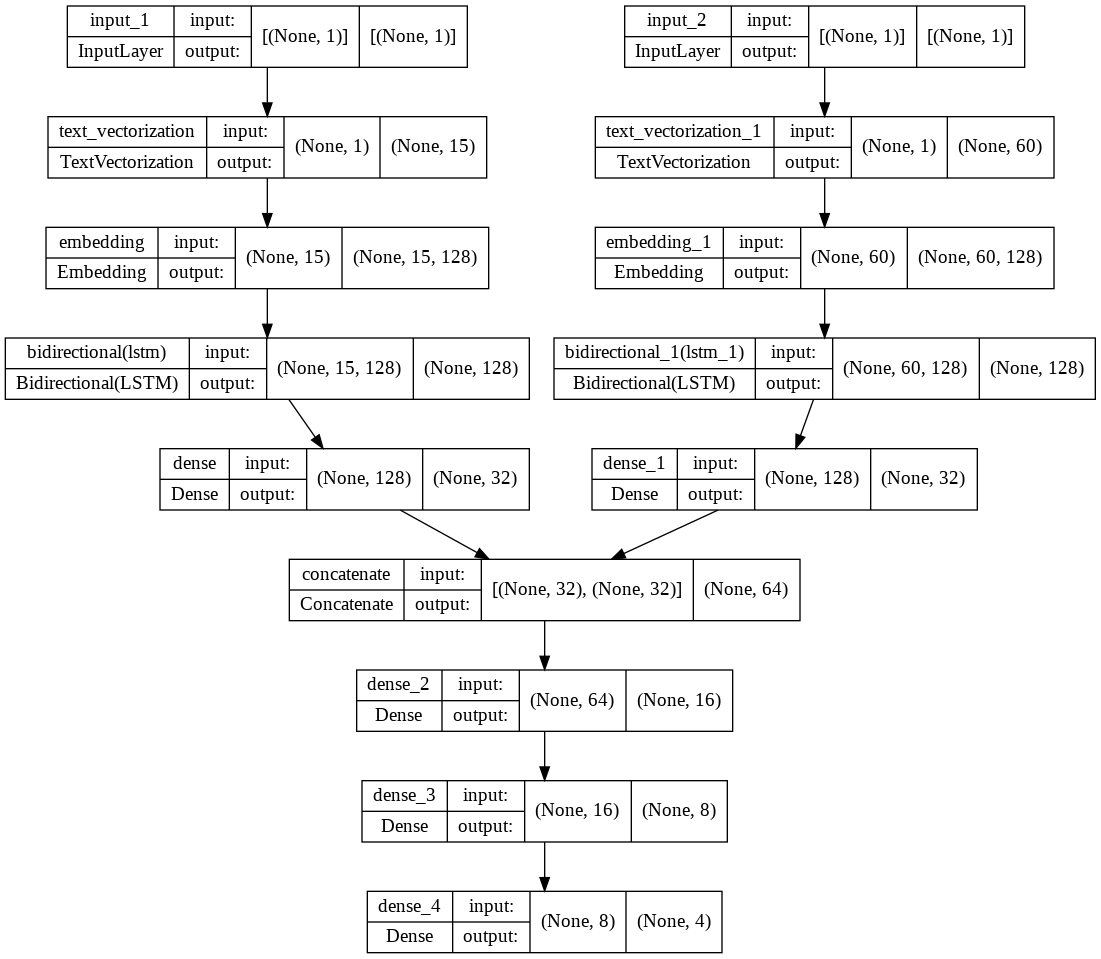

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
history = model.fit(training_data,
                    epochs=10,
                    steps_per_epoch=len(training_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/10
9/9 [==============================] - 29s 1s/step - loss: 1.2658 - accuracy: 0.3546 - val_loss: 0.9565 - val_accuracy: 0.5003
Epoch 2/10
9/9 [==============================] - 7s 805ms/step - loss: 0.7717 - accuracy: 0.6490 - val_loss: 0.6264 - val_accuracy: 0.8062
Epoch 3/10
9/9 [==============================] - 7s 786ms/step - loss: 0.4323 - accuracy: 0.8743 - val_loss: 0.4251 - val_accuracy: 0.8780
Epoch 4/10
9/9 [==============================] - 7s 793ms/step - loss: 0.2659 - accuracy: 0.9197 - val_loss: 0.3465 - val_accuracy: 0.8894
Epoch 5/10
9/9 [==============================] - 7s 795ms/step - loss: 0.1952 - accuracy: 0.9400 - val_loss: 0.3457 - val_accuracy: 0.8938
Epoch 6/10
9/9 [==============================] - 7s 797ms/step - loss: 0.1496 - accuracy: 0.9551 - val_loss: 0.3568 - val_accuracy: 0.8933
Epoch 7/10
9/9 [==============================] - 7s 798ms/step - loss: 0.1121 - accuracy: 0.9673 - val_loss: 0.3929 - val_accuracy: 0.8952
Epoch 8/10
9/9 [======

In [15]:
model.evaluate(val_data)

3/3 [==============================] - 1s 250ms/step - loss: 0.5419 - accuracy: 0.8890


[0.5418931841850281, 0.889033317565918]